<center>
    <h3>Arnaud Chéridi</h3>
    <p>Étudiant en Master 2 Mathématiques Appliquées</p>
    <p>Projet individuel : Modélisation du risque de crédit (cas IFRS 9)</p>
    <p>Objectif : développer un modèle de PD (score > 65%) + LGD + simulation</p>
</center>

<center><h2> 3. Modélisation de la perte en cas de défaut <h2><center>

## 0. Import des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import shap
import joblib

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error

## 1. Chargements des données

In [2]:
train_final = pd.read_csv("data/train_final.csv")
test_final = pd.read_csv("data/test_final.csv")
full_df = pd.concat([train_final, test_final], axis=0)

In [3]:
index_keep = full_df[full_df["LGD_sim_NA"]==0].index

In [4]:
X = full_df.drop(columns=["TARGET", "SK_ID_CURR", "LGD_sim", "LGD_sim_NA"])
y = full_df["LGD_sim"]

## 2. Préparation des données (X, y, split)

Code repris du notebook : `02_modelisation_pd.ipynd`

In [5]:
# Séparation des colonnes
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Préprocesseur
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

# Entraînement
X_transformed = preprocessor.fit_transform(X)
X_transformed[index_keep, :]

array([[-0.57513695,  0.446895  ,  1.77043183, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57513695, -0.15711426, -0.69008768, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57513695, -0.21751519, -0.18756416, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.81302455, -0.25778247, -0.78141454, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57513695,  0.14489037, -1.17364592, ...,  0.        ,
         0.        ,  0.        ],
       [-0.57513695, -0.35845068, -0.80845136, ...,  0.        ,
         0.        ,  0.        ]], shape=(142494, 217))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

## 3. Modélisation : Random Forest / LightGBM / XGBoost

Code repris du notebook : `02_modelisation_pd.ipynd`

In [7]:
# Random Forest
pipe_rf = Pipeline([
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# LightGBM
pipe_lgbm = Pipeline([
    ("model", LGBMRegressor(verbose=-1 ,random_state=42))
])

# XGBoost
pipe_xgb = Pipeline([
    ("model", XGBRegressor(use_label_encoder=False, eval_metric='mlogloss', random_state=42),)
])

In [8]:
# Grid pour Random Forest
param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10]
}

# Grid pour LightGBM
param_grid_lgbm = {
    "model__n_estimators": [100, 200],
    "model__num_leaves": [31, 50]
}

# Grid pour XGBoost
param_grid_xgb = {"model__n_estimators": [100, 200],
                  "model__max_depth": [3, 6]}

# Grille et pipelines associés
grids = [
    ("RandomForest", pipe_rf, param_grid_rf),
    ("LightGBM", pipe_lgbm, param_grid_lgbm),
    ("XGBoost", pipe_xgb, param_grid_xgb)
]

Lancement de la recherche des hyperparamètres via le score $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

In [9]:
# Résultats
best_models = {}

for name, pipeline, param_grid in grids:
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search
    print(f"\n>>> {name}")
    print("Best params:", grid_search.best_params_)
    print("Best MSE:", grid_search.best_score_)

/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack


>>> RandomForest
Best params: {'model__max_depth': 10, 'model__n_estimators': 200}
Best MSE: -0.0009848085012328107


/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack


>>> LightGBM
Best params: {'model__n_estimators': 200, 'model__num_leaves': 50}
Best MSE: -0.0009117918621286865


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:43:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/xgboost/training.py:183: UserWarni


>>> XGBoost
Best params: {'model__max_depth': 6, 'model__n_estimators': 100}
Best MSE: -0.0009575752164196986


## 4. Évaluation des performances – Choix final du modèle

Pour chaque modèle sélectionné :
- Prédiction sur le jeu de test
- Affichage du $R^2$ et du $RMSE$.

Objectif : comparer les performances finales sur des données non vues.

In [14]:
for name, grid in best_models.items():
    print(f"\n{name}")

    best_model = grid.best_estimator_

    # Prédictions
    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R² score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")


RandomForest
R² score: 0.6729
RMSE: 0.0313

LightGBM
R² score: 0.6969
RMSE: 0.0301

XGBoost
R² score: 0.6828
RMSE: 0.0308


/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Les performances des trois modèles testés sont évaluées selon deux métriques principales :

- **R² (coefficient de détermination)** : proportion de la variance expliquée par le modèle. Plus il est proche de 1, meilleure est la prédiction.
- **RMSE (Root Mean Squared Error)** : erreur quadratique moyenne. Plus elle est faible, plus le modèle est précis.

| Modèle        | R² Score   | RMSE       |
|---------------|------------|------------|
| RandomForest  | 0.6729     | 0.0313     |
| LightGBM      | **0.6969** | **0.0301** |
| XGBoost       | 0.6828     | 0.0308     |

---

### Analyse comparative

- Le **modèle LightGBM** obtient les **meilleurs scores**, avec :
  - le **plus haut R²** (0.8126) → il explique ~81,3 % de la variance cible,
  - la **plus faible erreur RMSE** (0.0345) → il génère les prédictions les plus précises.

- **XGBoost** est légèrement derrière, performant mais un peu moins précis que LightGBM.

- **RandomForest** reste robuste mais moins performant que les modèles de gradient boosting.

---

### Conclusion

**LightGBM est le meilleur choix** pour cette tâche de régression, combinant précision et généralisation. Il sera utilisé pour les simulations et les prévisions futures.

In [11]:
best_params_light = best_models["LightGBM"].best_params_
model_params_light = {
    key.split("model__")[1]: value
    for key, value in best_params_light.items()
    if key.startswith("model__")
}

model_lgd_light = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LGBMRegressor(**model_params_light))
])

model_lgd_light.named_steps["model"].fit(
    preprocessor.transform(X), y
)

,boosting_type,'gbdt'
,num_leaves,50
,max_depth,-1
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### 6. Interprétabilité (SHAP, importance des variables)

Code repris du notebook : `02_modelisation_pd.ipynd`

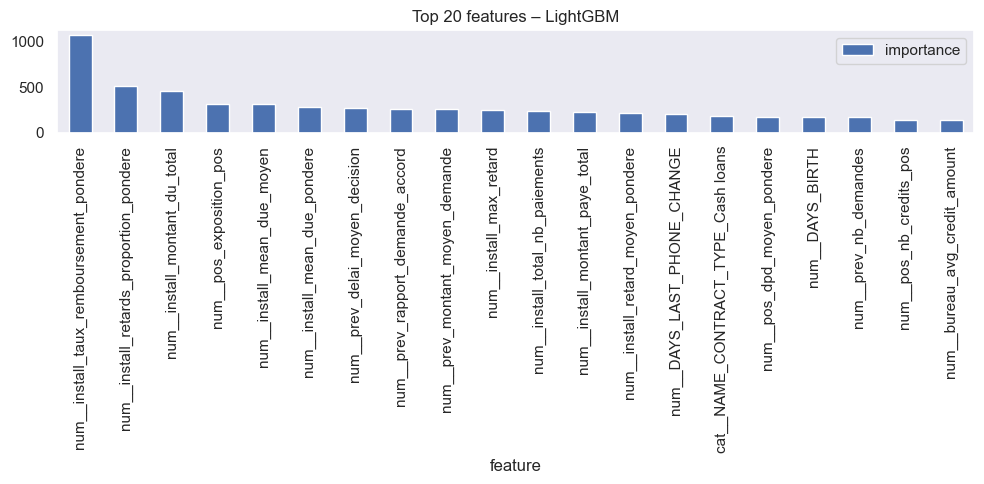

100%|===================| 355986/356255 [15:52<00:00]        

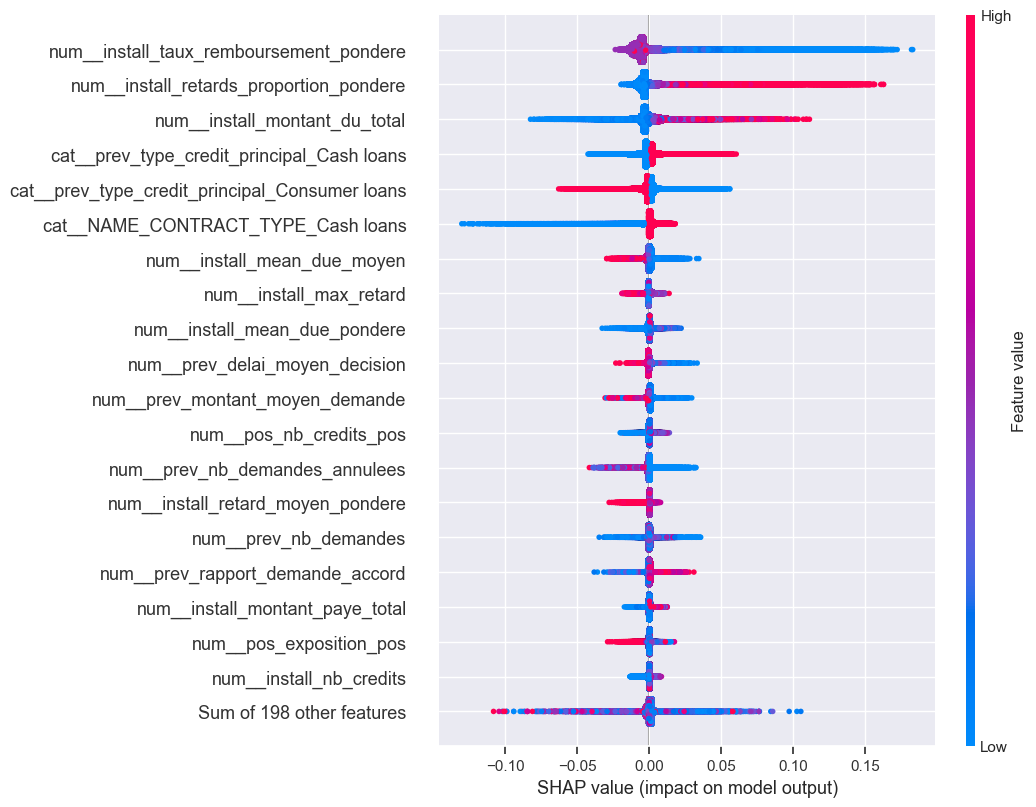

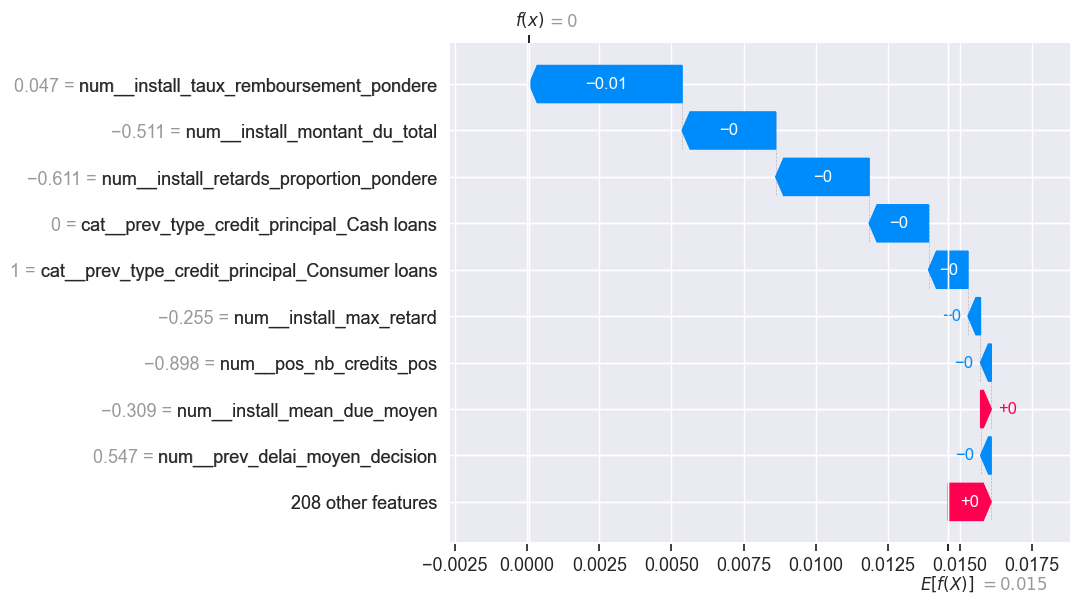

In [12]:
# Étape 1 : accéder au modèle et aux noms de features
model = model_lgd_light.named_steps["model"]
feature_names = model_lgd_light.named_steps["preprocessing"].get_feature_names_out()

# Étape 2 : importer les importances et afficher les plus importantes
importances = model.feature_importances_

feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp.sort_values(by="importance", ascending=False).head(20).plot.bar(x="feature", y="importance", figsize=(10, 5))
plt.title("Top 20 features – LightGBM")
plt.grid()
plt.tight_layout()
plt.show()

# Étape 3 : transformer X en DataFrame pour récupérer le nom des variables
X_transformed = pd.DataFrame(
    model_lgd_light.named_steps["preprocessing"].transform(X),
    columns=model_lgd_light.named_steps["preprocessing"].get_feature_names_out(),
    index=X.index
)

# Étape 4 : SHAP
explainer = shap.Explainer(model, X_transformed)
shap_values = explainer(X_transformed, check_additivity=False)

shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.waterfall(shap_values[0])

#### 1. **Top 20 features selon LightGBM (Feature Importances)**

Le graphe ci-dessous montre les 20 variables les plus importantes dans le modèle LightGBM basé sur le **gain** :

- La variable `install_taux_remboursement_pondere` est de loin la plus influente. Elle reflète le ratio de remboursement pondéré sur les échéances prévues.
- Suivent les variables liées aux **retards de paiement** (`install_retards_proportion_pondere`, `install_max_retard`) et aux **montants dus ou payés**.
- Les variables des sources de score externes (`EXT_SOURCE_2`, `EXT_SOURCE_3`) et la **durée depuis le dernier changement de téléphone** (`DAYS_LAST_PHONE_CHANGE`) apparaissent aussi, mais en bas du classement.

Cela met en évidence que les comportements historiques de remboursement (retards, montants payés, fréquence) sont les principaux facteurs explicatifs du niveau d'exposition au défaut.

---

#### 2. **Beeswarm plot (SHAP - Importance globale)**

Le graphe SHAP global permet de :

- Visualiser **l’impact directionnel** de chaque variable sur la prédiction (valeurs SHAP positives → augmentent l’EAD, négatives → la réduisent).
- Comprendre l’effet des **valeurs hautes (rouge)** ou **basses (bleu)** sur la sortie du modèle.

**Exemples** :
- Des valeurs **basses** de `install_taux_remboursement_pondere` (en bleu) sont **associées à une forte EAD**, ce qui est logique : moins le client rembourse, plus l’exposition potentielle est élevée.
- Un **taux élevé de retard pondéré** contribue aussi positivement à la prédiction.
- Des variables comme `install_montant_payé_total` ou `AMT_ANNUITY` ont un effet plus modéré mais non négligeable.

---

#### 3. **Waterfall plot (SHAP - Explication locale)**

Le waterfall plot explique **la prédiction pour un individu donné** :

- La prédiction finale du modèle est ici de **`f(x) ≈ 0.035`**.
- Les variables les plus contributives sont :
  - `install_taux_remboursement_pondere` et `install_retards_proportion_pondere` (valeurs faibles) réduisent fortement l’EAD estimée.
  - D’autres variables comme `install_mean_due_moyen`, `montant_du_total` ou `AMT_ANNUITY` tirent au contraire la prédiction vers le haut.

Ce type de visualisation permet une **interprétation locale** de la prédiction, essentielle dans les contextes d'audit ou de transparence réglementaire.

---

### Conclusion

- Le modèle LightGBM identifie des variables explicatives cohérentes économiquement, en particulier liées à l’**historique de remboursement client**.
- L’interprétation combinée via les **feature importances** et **SHAP values** permet d’atteindre à la fois une **compréhension globale** et une **analyse individuelle** des prédictions.

## 7. Sauvegarde du modèle

In [13]:
joblib.dump(model_lgd_light, "model_lgd.pkl")

['model_lgd.pkl']